### Configuration

In [1]:
import sqlite3
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import *
import sys
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import psutil
import random
import numpy as np
import seaborn as sns

In [2]:
spark = SparkSession.builder \
    .appName("suggestify") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.instances", "1") \
    .getOrCreate()

spark.conf.set("spark.sql.shuffle.partitions", 200)
spark.conf.set("spark.default.parallelism", 200)

your 131072x1 screen size is bogus. expect trouble
25/03/24 17:42:35 WARN Utils: Your hostname, SS22-3006087600 resolves to a loopback address: 127.0.1.1; using 172.31.219.180 instead (on interface eth0)
25/03/24 17:42:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/24 17:42:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
venv_path = os.path.dirname(os.path.dirname(sys.executable))

#conseguir direccion del proyecto, donde esta la bd
project_path = os.path.dirname(venv_path)

### Dataframe retrieval

In [3]:
sqlite_conn = sqlite3.connect(project_path+"/extracted.db") #clase
#sqlite_conn = sqlite3.connect(venv_path+"/extracted.db") #portatil
#sqlite_conn = sqlite3.connect("/home/enekobarba/bigdata/extracted.db")

cursor = sqlite_conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in SQLite:", tables)

df = pd.read_sql("SELECT * FROM extracted", sqlite_conn)

sqlite_conn.close()

df.head()

Tables in SQLite: [('extracted',)]


,track_uri,track_name,artist_name,artist_uri,album_name,album_uri,duration_ms,danceability,energy,key,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,fduration_ms,time_signature
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott,spotify:artist:2wIVse2owClT7go1WT98tk,The Cookbook,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,0.904,0.813,4,...,0.0471,0.810,125.461,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Toxic,Britney Spears,spotify:artist:26dSoYclwsYLMAKD3tpOr4,In The Zone,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,0.774,0.838,5,...,0.2420,0.924,143.040,audio_features,6I9VzXrHxO9rA9A5euc8Ak,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/tracks/6I9VzXrHxO9r...,https://api.spotify.com/v1/audio-analysis/6I9V...,198800,4
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,Beyoncé,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Dangerously In Love (Alben für die Ewigkeit),spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,0.664,0.759,2,...,0.0598,0.701,99.252,audio_features,0WqIKmW4BTrj3eJFmnCKMv,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj...,https://api.spotify.com/v1/audio-analysis/0WqI...,235933,4
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Rock Your Body,Justin Timberlake,spotify:artist:31TPClRtHm23RisEBtV3X7,Justified,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,0.892,0.714,4,...,0.0521,0.817,100.972,audio_features,1AWQoqb9bSvzTjaLralEkT,spotify:track:1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/tracks/1AWQoqb9bSvz...,https://api.spotify.com/v1/audio-analysis/1AWQ...,267267,4
4,spotify:track:1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,Shaggy,spotify:artist:5EvFsr3kj42KNv97ZEnqij,Hot Shot,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,0.853,0.606,0,...,0.3130,0.654,94.759,audio_features,1lzr43nnXAijIGYnCT8M8H,spotify:track:1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/tracks/1lzr43nnXAij...,https://api.spotify.com/v1/audio-analysis/1lzr...,227600,4


In [4]:
df.shape

(2261644, 25)

We'll now separate the columns from which we can get insights into what relationships and patterns our data hides. This next dataframe, "df_sample_others", is the collection of columns containing uris and references, that we will maybe later on use, but for now, we'll put them aside and focus our attention into "df_sample".

Defining the track_uri as a id for each song could be a simple option, however, as it contains letters, it will later on crash. Taking that into account, we'll define a unique identifier based on the track_uri as follows:

In [5]:
df['track_id'] = df['track_uri'].astype('category').cat.codes


In [6]:
df_sample = df[["track_id", "track_name", "artist_name", "album_name", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]]

df_sample_others = df[["track_id", "track_uri", "artist_uri", "album_uri", "type", "uri", "id", "fduration_ms", "track_href", "analysis_url"]]

We can now clean the data, and separate the numerical data from the categorical, using the id in both as identification

In [7]:
df_sample_numerical = df_sample[["track_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]]

df_sample_categorical = df_sample[["track_id", "track_name", "artist_name", "album_name"]]

In [8]:
df_sample.set_index("track_id", inplace=True)
df_sample_others.set_index("track_id", inplace=True)
df_sample_numerical.set_index("track_id", inplace=True)
df_sample_categorical.set_index("track_id", inplace=True)

### Intento de KMeans con Pandas

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [13]:
#apply PCA (sin std)
pca = PCA(n_components=4) 
df_pca = pca.fit_transform(df_sample_numerical[["duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]])

### PC1, PC2

In [14]:
#KMeans with k=10
kmeans = KMeans(n_clusters=10, random_state=42)
df_sample['cluster'] = kmeans.fit_predict(df_pca)

/tmp/ipykernel_1017/2543915891.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['cluster'] = kmeans.fit_predict(df_pca)


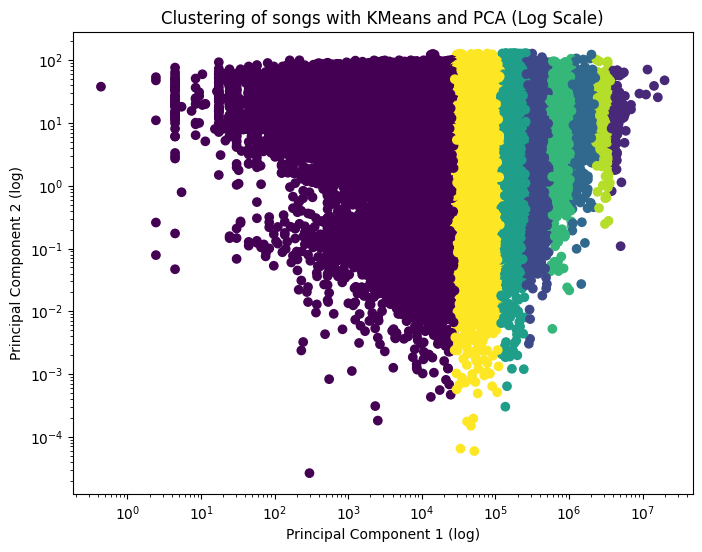

In [15]:
#visualization
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_sample['cluster'], cmap='viridis')
plt.xscale('log')
plt.yscale('log')
plt.title('Clustering of songs with KMeans and PCA (Log Scale)')
plt.xlabel('Principal Component 1 (log)')
plt.ylabel('Principal Component 2 (log)')
plt.show()

-----------------------------------------------
Percentage of explained variance per component:
-----------------------------------------------
[9.99999963e-01 3.57489457e-08 1.20753227e-09 5.05366986e-10]


Text(0, 0.5, 'Explained variance')

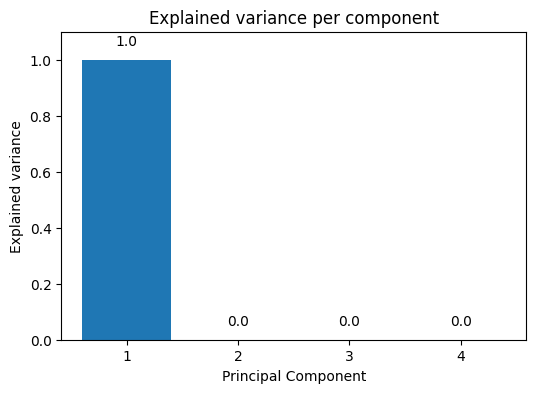

In [14]:
print('-----------------------------------------------')
print('Percentage of explained variance per component:')
print('-----------------------------------------------')
print(pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(pca.n_components_) + 1,
    height = pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df_sample.columns)) + 1, pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Explained variance per component')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained variance')

In [15]:
print('-------------------------------------------------------------------------')
print('Explainability per variable for each the first four principal components:')
print('-------------------------------------------------------------------------')
print(pca.components_)

-------------------------------------------------------------------------
Explainability per variable for each the first four principal components:
-------------------------------------------------------------------------
[[ 1.00000000e+00 -7.97500506e-08 -1.24868594e-08  2.41900708e-08
  -2.24781959e-06 -1.07429993e-07 -2.45915260e-08 -8.53897188e-08
   2.75233937e-07  2.79350304e-08 -2.61438500e-07 -1.97118435e-06
   5.85672989e-08]
 [ 2.06043271e-06 -1.03691773e-05  2.14189063e-03  1.04913321e-03
   4.03440462e-02  5.21135027e-05 -8.26313338e-07 -2.45704885e-03
  -5.82929961e-04  9.15899683e-05  1.04008357e-03  9.99178961e-01
   7.76439780e-04]
 [ 2.16707859e-06  1.10103432e-02  3.66301743e-02  3.48468600e-02
   9.96579282e-01 -3.27109059e-03  1.10958406e-03 -3.79423064e-02
  -2.50626172e-02  3.41430292e-03  1.47753046e-02 -4.04886057e-02
   1.42637255e-02]
 [-1.04327751e-07  8.40387667e-04  1.15462463e-04  9.99153216e-01
  -3.50202080e-02 -2.14989268e-02  6.74999382e-04 -3.89296310

In [16]:
print('--------------------------------------------------------------')
print('Explainability per variable for the first (9.99999963e-01) PC:')
print('--------------------------------------------------------------')
# Obtener los loadings del primer componente
pc1_loadings = pca.components_[0]

# Nombres de las variables originales
variables = ["duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", 
             "instrumentalness", "liveness", "valence", "tempo", "time_signature"]

# Crear un DataFrame con los resultados
df_loadings = pd.DataFrame({
    'Variable': variables,
    'Explainability per variable PC1': pc1_loadings
})

df_loadings

--------------------------------------------------------------
Explainability per variable for the first (9.99999963e-01) PC:
--------------------------------------------------------------


,Variable,Explainability per variable PC1
0,duration_ms,1.000000e+00
1,danceability,-7.975005e-08
2,energy,-1.248686e-08
3,key,2.419007e-08
4,loudness,-2.247820e-06
5,mode,-1.074300e-07
6,speechiness,-2.459153e-08
7,acousticness,-8.538972e-08
8,instrumentalness,2.752339e-07
9,liveness,2.793503e-08


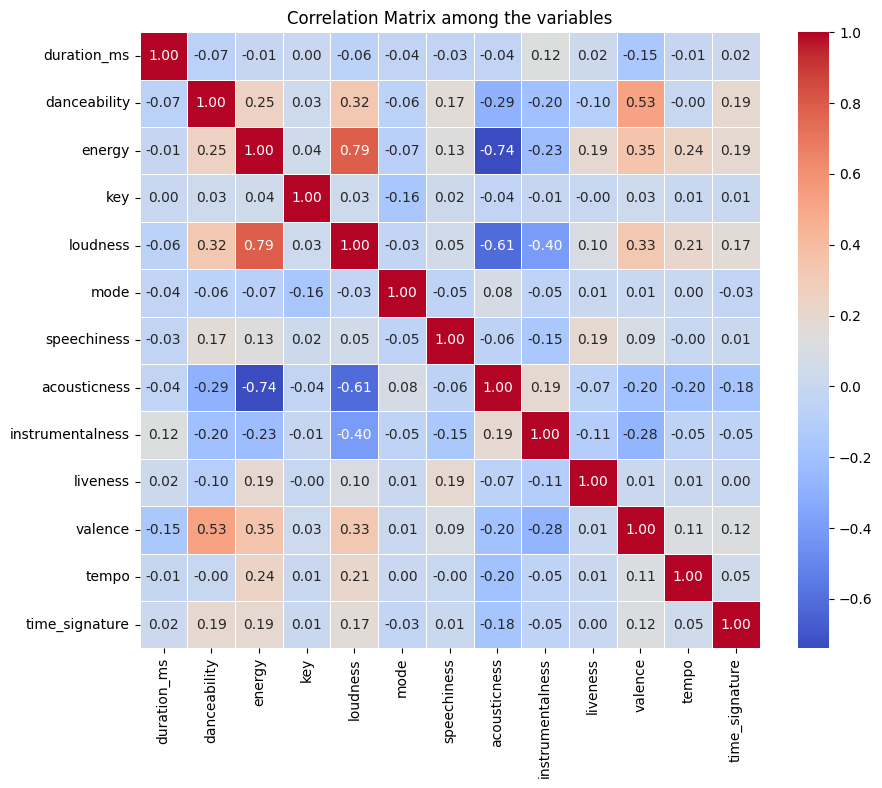

In [17]:
# Calcular la matriz de correlación
corr_matrix = df_sample_numerical[["duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", 
             "instrumentalness", "liveness", "valence", "tempo", "time_signature"]].corr()

# Crear un gráfico de calor para visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix among the variables")
plt.show()

### TSNE viejo

#### con 100

In [18]:
numerical_features = ["duration_ms", "danceability", "energy", "key", "loudness", 
                      "mode", "speechiness", "acousticness", "instrumentalness", 
                      "liveness", "valence", "tempo", "time_signature"]


scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_sample_numerical[numerical_features].iloc[:100])

In [19]:
tsne = TSNE(n_components=3, perplexity=50, random_state=42)
df_tsne = tsne.fit_transform(df_scaled)

In [20]:
df_sample_100 = df_sample.iloc[:100].copy()

kmeans = KMeans(n_clusters=10, random_state=42)
df_sample_100['cluster'] = kmeans.fit_predict(df_tsne)

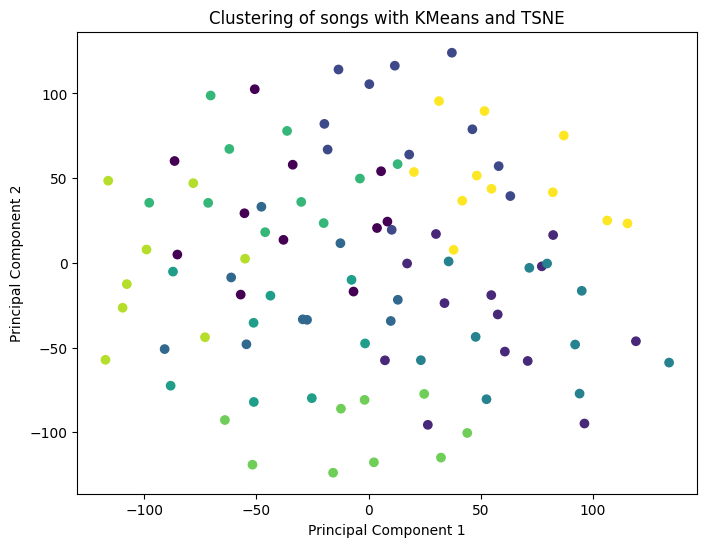

In [21]:
#visualization
plt.figure(figsize=(8, 6))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=df_sample_100['cluster'], cmap='viridis')
plt.title('Clustering of songs with KMeans and TSNE')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

#### con 1000

In [22]:
numerical_features = ["duration_ms", "danceability", "energy", "key", "loudness", 
                      "mode", "speechiness", "acousticness", "instrumentalness", 
                      "liveness", "valence", "tempo", "time_signature"]


scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_sample_numerical[numerical_features].iloc[:1000])

In [23]:
tsne = TSNE(n_components=3, perplexity=50, random_state=42)
df_tsne = tsne.fit_transform(df_scaled)

In [24]:
df_sample_1000 = df_sample.iloc[:1000].copy()

kmeans = KMeans(n_clusters=10, random_state=42)
df_sample_1000['cluster'] = kmeans.fit_predict(df_tsne)

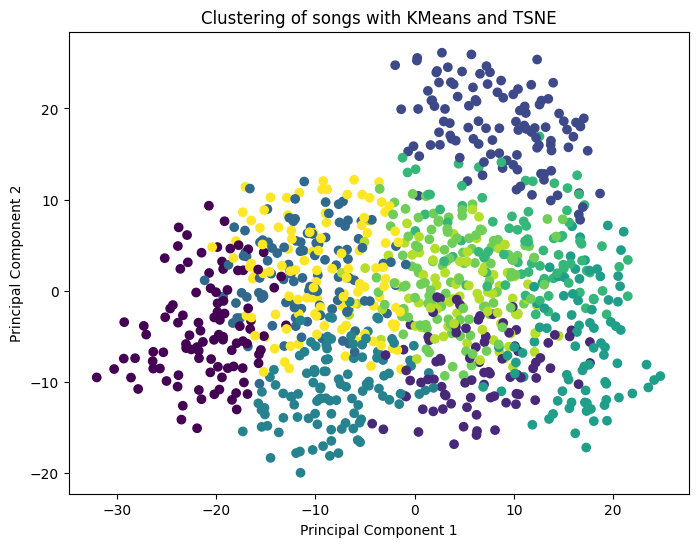

In [25]:
#visualization
plt.figure(figsize=(8, 6))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=df_sample_1000['cluster'], cmap='viridis')
plt.title('Clustering of songs with KMeans and TSNE')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### Celdas de Voronoi

In [10]:
from scipy.spatial import Voronoi, voronoi_plot_2d

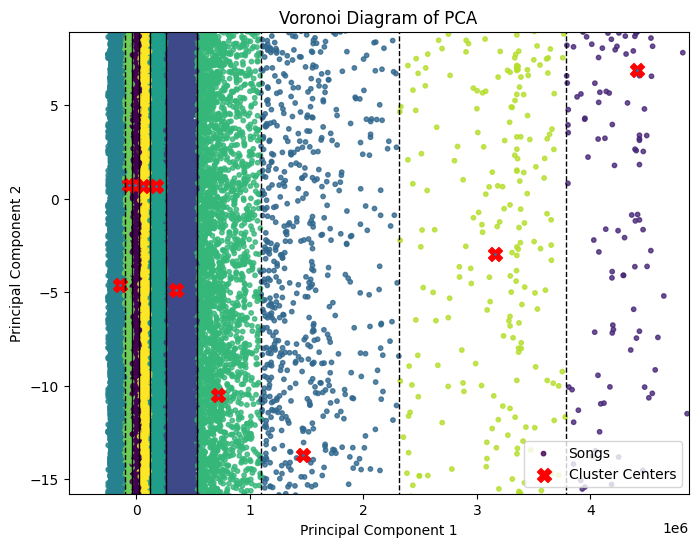

In [ ]:
df_pca_2d = df_pca[:, :2]

centers_4d = kmeans.cluster_centers_

centers_2d = centers_4d[:, :2]

vor = Voronoi(centers_2d)

fig, ax = plt.subplots(figsize=(8, 6))

voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors="black", line_width=1, point_size=2)

scatter = ax.scatter(df_pca_2d[:, 0], df_pca_2d[:, 1],
                     c=df_sample['cluster'], cmap='viridis', s=10, alpha=0.8,
                     label='Songs')

ax.scatter(centers_2d[:, 0], centers_2d[:, 1],
           marker='X', s=100, color='red', label='Cluster Centers')

#plt.xscale("log")
#plt.yscale("log")

plt.title('Voronoi Diagram of PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [11]:
vor = Voronoi(df_sample_numerical.iloc[:100])
fig = voronoi_plot_2d(vor)
plt.show()

: 

: 

### Recommendations to user content-based

In [26]:
UID=1

se supone que se le recomiendan unas canciones y les da like o no o super

dislike: -1
like: 1
saltar: 0
super like :2

In [27]:
ratings=pd.DataFrame( columns=["user", "track_id", "rating"])

In [28]:
rating_map = {
    "dislike": -1,
    "like": 1,
    "saltar": 0,
    "super like": 2
}


while ratings.shape[0] < 20:
    num_aleatorio = random.randint(0, len(df_sample) - 1)
    
    #info de canción
    try:
        cancion = df_sample.loc[num_aleatorio]
        nombre_cancion = cancion['track_name']
        artista = cancion['artist_name']
    except (KeyError, IndexError):
        nombre_cancion = "Canción desconocida"
        artista = "Artista desconocido"

    
    while True:
        input_usuario = input(f"\n🎵 Canción: {nombre_cancion} - {artista}\n""Ingrese su calificación (dislike/like/saltar/super like): ").strip().lower()        
        if input_usuario in rating_map:
            rating = rating_map[input_usuario]
            break
        else:
            print("⚠️ Entrada inválida. Ingrese una opción válida: dislike, like, saltar, super like.")

    nueva_fila = [UID, num_aleatorio, rating]
    ratings.loc[ratings.shape[0]] = nueva_fila


dislike: -1
like: 1
saltar: 0
super like :2

In [29]:
ratings

,user,track_id,rating
0,1,2151764,-1
1,1,1032915,-1
2,1,252444,-1
3,1,585472,-1
4,1,1235539,-1
5,1,2210061,-1
6,1,447463,1
7,1,1050075,-1
8,1,1787049,-1
9,1,56245,-1


In [30]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd

In [31]:
scaler = StandardScaler()
normalized_features = scaler.fit_transform(df_sample_numerical)

In [32]:
reduced_features = pca.fit_transform(normalized_features).astype(np.float32)  #pa menor precisión

In [33]:
#modelo ANN
nn_model = NearestNeighbors(
    n_neighbors=50,
    metric='cosine',
    algorithm='auto', 
    n_jobs=-1
).fit(reduced_features)

In [34]:
def content_based_recommendation(user_ratings, df, top_n=10, diversity=0.7):
    user_tracks = user_ratings['track_id'].values
    valid_mask = df.index.isin(user_tracks)
    user_ratings_filtered = user_ratings[user_ratings['track_id'].isin(df.index)]
    
    if len(user_ratings_filtered) == 0:
        return df.sample(min(top_n, len(df)))
    
    positive_mask = user_ratings_filtered['rating'] > 0
    positive_indices = df.index.get_indexer(user_ratings_filtered[positive_mask]['track_id'])
    
    if len(positive_indices) == 0:
        return df.sample(min(top_n, len(df)))
    
    #buscar neighbors
    batch_size = 100
    all_indices = []
    
    for i in range(0, len(positive_indices), batch_size):
        batch = positive_indices[i:i+batch_size]
        _, indices = nn_model.kneighbors(reduced_features[batch])
        all_indices.extend(indices.ravel())
    
    unique_indices, counts = np.unique(all_indices, return_counts=True)
    rated_mask = np.isin(unique_indices, df.index.get_indexer(user_ratings['track_id']))
    
    #puntuacion
    scores = counts * (1 - diversity) + np.random.rand(len(counts)) * diversity
    scores[rated_mask] = -np.inf
    
    top_indices = unique_indices[np.argsort(scores)[-top_n:][::-1]]
    
    return df.iloc[top_indices]

In [ ]:
#recomendar
recommendations = content_based_recommendation(
    user_ratings=ratings,
    df=df_sample,
    top_n=5,
    diversity=0.3  #0=máxima similitud, 1=máxima diversidad
)

print("Recomendaciones:")
recommendations

Recomendaciones:


,track_name,artist_name,album_name,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,cluster
track_id,,,,,,,,,,,,,,,,,
1418035,Death Comes Ripping - Fox Studio 1983,Misfits,"Earth A.D. / Die, Die My Darling",113733,0.308,0.854,11,-14.914,0,0.1180,0.00162,0.00270,0.447,0.0609,145.092,4,4
1900458,"Jesus, We Love You - Live",Maranatha! Music,Top 50 Praise Songs 2016,299986,0.461,0.429,9,-8.587,1,0.0282,0.34200,0.00000,0.234,0.1870,116.016,3,9
653242,Song for Physical Healing,Wind Chimes 4 Life,Rain and Wind Chimes,1030655,0.165,0.571,10,-30.763,0,0.1350,0.19500,0.95000,0.117,0.0223,111.189,4,6
566165,Need to Know,House Of Shem,Keep Rising,267333,0.786,0.593,9,-6.712,0,0.0408,0.00270,0.00557,0.059,0.9620,142.041,4,0
691974,Heartbeat,Madi Diaz,We Threw Our Hearts in the Fire,222840,0.775,0.673,4,-6.320,0,0.0315,0.37000,0.00281,0.158,0.4120,121.472,4,0


# Otros

## PC3, PC4

In [ ]:
df_pca_34 = pd.DataFrame(df_pca[:, 2:], columns=['PC3', 'PC4'])

In [ ]:
#KMeans with k=10
kmeans = KMeans(n_clusters=10, random_state=42)
df_sample['cluster'] = kmeans.fit_predict(df_pca_34)

In [ ]:
# Visualización corregida
plt.figure(figsize=(8, 6))
plt.scatter(df_pca_34['PC3'], df_pca_34['PC4'], c=df_sample['cluster'], cmap='viridis')
plt.title('Clustering of songs with KMeans and PCA')
plt.xlabel('Principal Component 3')
plt.ylabel('Principal Component 4')
plt.colorbar(label='cluster')
plt.show()

## Spark

### Spark Dataframe

In [ ]:
#columns for clustering
feature_columns = ["danceability", "energy", "key", "loudness", "mode",
                   "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_raw")
assembled_df = assembler.transform(spark_df).repartition(500).cache()
assembled_df.count()

### Intento de KMeans con Spark

In [ ]:
schema = StructType([
    StructField("track_uri", StringType(), True),
    StructField("track_name", StringType(), True),
    StructField("artist_name", StringType(), True),
    StructField("album_name", StringType(), True),
    StructField("duration_ms", IntegerType(), True),
    StructField("danceability", FloatType(), True),
    StructField("energy", FloatType(), True),
    StructField("key", IntegerType(), True),
    StructField("loudness", FloatType(), True),
    StructField("mode", IntegerType(), True),
    StructField("speechiness", FloatType(), True),
    StructField("acousticness", FloatType(), True),
    StructField("instrumentalness", FloatType(), True),
    StructField("liveness", FloatType(), True),
    StructField("valence", FloatType(), True),
    StructField("tempo", FloatType(), True),
    StructField("time_signature", IntegerType(), True)
])

spark_df = spark.createDataFrame(df_sample, schema=schema)

spark_df.show(5)

In [ ]:
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df).select("features").cache()
scaled_df.count()

In [ ]:
#KMeans with 10 clusters
kmeans = KMeans(k=10, seed=42, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(scaled_df)

In [ ]:
#predictions
clustered_df = model.transform(assembled_df)

In [ ]:
#plotting the clusters
pandas_df = clusters_df.select("danceability", "energy", "cluster").toPandas() #transform to pandas for plotting
plt.figure(figsize=(10, 6))
for cluster in range(10):
    cluster_data = pandas_df[pandas_df['cluster'] == cluster]
    plt.scatter(cluster_data['danceability'], cluster_data['energy'], label=f'Cluster {cluster}')

plt.title('Clustering de canciones por danceability y energy')
plt.xlabel('Danceability')
plt.ylabel('Energy')
plt.legend()
plt.show()